# Final Report - Data Science 
## Bachelor in Computer Science / PUCPR

Professor Jean Paul Barddal

André de Macedo Wlodkovski - andremacwlod@gmail.com

João Vitor Borges - joaovitbor@hotmail.com

Kalebe Rodrigues Szlachta - kalebeszlachta@gmail.com

Lucas Eduardo Giovanini Marrega - lucas_giovanini14@hotmail.com


2020


# Introdução

O conteúdo do dataset apresentado nesse notebook contém diversos dados econômicos e sociais voltados à população. A classe Target diz se tal pessoa é inadimplmente ou não. Tendo isso em mente, realizaremos uma análise de alguns dados apresentados ao longo desse notebook a fim de classificar a probabilidade da pessoa ser um mal pagador ou não.

Dados sensíveis e que podem demonstrar alguma informação pessoal serão descartados.


# Importing libraries

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import binom
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
import matplotlib
from sklearn.feature_selection import SelectKBest

# Loading the data

Below, load the data using pandas and make all the necessary data cleansing so that all data types are correct for posterior analysis.

In [333]:
# load your data here
df = pd.read_csv('train.csv', na_values=[-9999,]) # importando a base e atribuindo valores que são -9999 como NaN

In [334]:
df_test = pd.read_csv("test.csv")

In [335]:
df.drop(['ORIENTACAO_SEXUAL', 'RELIGIAO', 'PERCENTMASCCEP'], axis=1, inplace=True) #removendo campos que dizem respeito a privacidade
df_test.drop(['ORIENTACAO_SEXUAL', 'RELIGIAO', 'PERCENTMASCCEP'], axis=1, inplace=True) #removendo campos que dizem respeito a privacidade

In [336]:
headers = list(df)
need_special_filter = [
                       'ESTIMATIVARENDA', 
                       'QTDDECLARACAOPAGAR10', 
                       'RESTITUICAOAGENCIAALTARENDA'
                       ] #lista de dados que devem ser tratados com cautela, não podem passar por uma verificação simples (podem aceitar negativo, por exemplo)

no_negative =['DISTCENTROCIDADE','DISTZONARISCO','MENORRENDACASA','MAIORRENDACASA',
              'SOMARENDACASA','MEDIARENDACASA','MEDIAIDADECASA','PERCENTANALFABETOCEP',
              'PERCENTMEDIOCEP','PERCENTSUPERIORCEP','PERCENTBOLSAFAMILIACEP',
              'MEDIARENDACEP','QTDAUTOMOVELMUNICIPIO']

booleans = []

# filtrar valores específicos

for header in no_negative:  
                              # remove valores negativos
  df[header].values[(df[header].values < 0)] = np.NaN

  df[header].replace("-","")


for header in headers:
  if header == 'HS_CPF':                        # cpf não pode ser negativo, nem maior que 11 dígitos
    df['HS_CPF'] = df['HS_CPF'].astype(np.float64)
    df['HS_CPF'].values[(df['HS_CPF'].values < 0)|(df['HS_CPF'].values>99999999999)] = np.NaN
  elif header == 'BOLSAFAMILIA':                 # todos que não forem 1(da bolsa familia) são 0
    df['BOLSAFAMILIA'].values[(df['BOLSAFAMILIA'].values != 1)] = 0
  elif header not in need_special_filter:
    df[header].values[(df[header].values < 0)|(df[header].values>99999)] = np.NaN
    #se os valores nao passarem na validação, atribuiremos None

D:\Usuario\Anaconda3_2\envs\lixoLearning\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
D:\Usuario\Anaconda3_2\envs\lixoLearning\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less
D:\Usuario\Anaconda3_2\envs\lixoLearning\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


In [337]:
#observando dados nulos
df.isnull().sum(axis=1).astype('float64') < 30
df.head()

,HS_CPF,TEMPOCPF,DISTCENTROCIDADE,DISTZONARISCO,QTDENDERECO,QTDEMAIL,QTDCELULAR,CELULARPROCON,QTDFONEFIXO,TELFIXOPROCON,...,QTDDECLARACAOISENTA,QTDDECLARACAO10,QTDDECLARACAOREST10,QTDDECLARACAOPAGAR10,RESTITUICAOAGENCIAALTARENDA,BOLSAFAMILIA,ANOSULTIMARESTITUICAO,ANOSULTIMADECLARACAO,ANOSULTIMADECLARACAOPAGAR,TARGET
0,4089.0,20.314066,NaN,NaN,0.225217,NaN,1.254827,0.0,1.359449,0.0,...,2.801363,NaN,0.972806,0.352495,0.0,0.0,NaN,11.637502,NaN,0.0
1,505275.0,27.453985,2210.462581,NaN,0.763194,1.831920,3.414313,0.0,2.601777,0.0,...,NaN,0.552375,NaN,-0.270932,0.0,0.0,NaN,NaN,NaN,0.0
2,87104.0,10.251913,NaN,NaN,1.231079,NaN,3.309840,0.0,1.435696,0.0,...,NaN,NaN,0.238033,-0.095633,0.0,0.0,NaN,NaN,NaN,0.0
3,173070.0,26.325559,3162.427014,225.740504,2.309775,0.093034,0.980513,0.0,1.709005,0.0,...,NaN,3.922302,2.457990,0.300407,0.0,0.0,8.109879,4.087166,NaN,0.0
4,614153.0,3.575962,NaN,NaN,0.242762,0.330137,0.419016,0.0,0.838136,0.0,...,NaN,0.281776,NaN,-0.047788,0.0,0.0,NaN,NaN,NaN,1.0


In [338]:
df['HAS_NULL'] = df.isnull().any(axis=1).astype('float64')

df.fillna(0.0, inplace=True) #Substitui os valores NaN por 0
df.dtypes

HS_CPF                       float64
TEMPOCPF                     float64
DISTCENTROCIDADE             float64
DISTZONARISCO                float64
QTDENDERECO                  float64
                              ...   
ANOSULTIMARESTITUICAO        float64
ANOSULTIMADECLARACAO         float64
ANOSULTIMADECLARACAOPAGAR    float64
TARGET                       float64
HAS_NULL                     float64
Length: 68, dtype: object

# Univariate data analysis

### Distribuição da classe

0.0    0.903592
1.0    0.096408
Name: TARGET, dtype: float64

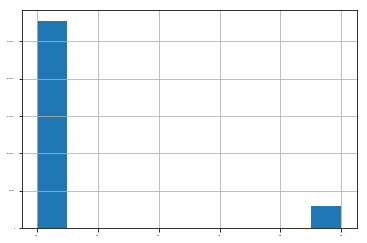

In [339]:
df['TARGET'].hist()
df['TARGET'].value_counts(normalize=True)

### Estatísticas sobre cada coluna

In [340]:
df.describe()

,HS_CPF,TEMPOCPF,DISTCENTROCIDADE,DISTZONARISCO,QTDENDERECO,QTDEMAIL,QTDCELULAR,CELULARPROCON,QTDFONEFIXO,TELFIXOPROCON,...,QTDDECLARACAO10,QTDDECLARACAOREST10,QTDDECLARACAOPAGAR10,RESTITUICAOAGENCIAALTARENDA,BOLSAFAMILIA,ANOSULTIMARESTITUICAO,ANOSULTIMADECLARACAO,ANOSULTIMADECLARACAOPAGAR,TARGET,HAS_NULL
count,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,...,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000,307307.000000
mean,324231.793679,15.241434,3131.282365,5013.460534,1.405726,0.478034,1.039178,0.002428,1.492457,0.011155,...,1.698597,0.876041,0.231550,0.003749,0.040878,0.472719,1.472403,0.455096,0.096408,0.999092
std,205772.548210,8.327629,4561.087549,14741.651105,1.298265,0.614090,1.187715,0.049210,1.473725,0.105027,...,3.001710,2.008054,1.152317,0.061112,0.198007,1.695393,3.195157,1.952969,0.295151,0.030118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-2.199068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,148193.500000,8.152220,0.000000,0.000000,0.457143,0.000000,0.044468,0.000000,0.293818,0.000000,...,0.000000,0.000000,-0.296765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,293945.000000,14.787738,1676.412980,0.329911,1.153636,0.233419,0.708083,0.000000,1.143102,0.000000,...,0.282480,0.107830,0.045898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,516015.500000,24.064845,4583.576417,1262.062634,2.002744,0.779989,1.547897,0.000000,2.240321,0.000000,...,1.360772,0.585822,0.435581,0.000000,0.000000,0.000000,1.032144,0.000000,0.000000,1.000000
max,698720.000000,28.861602,49715.645351,99836.253122,49.424152,7.139076,31.514443,1.000000,109.730127,1.000000,...,12.008105,11.704024,11.242833,1.000000,1.000000,18.483625,20.695308,26.665386,1.000000,1.000000


In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307307 entries, 0 to 307306
Data columns (total 68 columns):
HS_CPF                          307307 non-null float64
TEMPOCPF                        307307 non-null float64
DISTCENTROCIDADE                307307 non-null float64
DISTZONARISCO                   307307 non-null float64
QTDENDERECO                     307307 non-null float64
QTDEMAIL                        307307 non-null float64
QTDCELULAR                      307307 non-null float64
CELULARPROCON                   307307 non-null float64
QTDFONEFIXO                     307307 non-null float64
TELFIXOPROCON                   307307 non-null float64
INDICEEMPREGO                   307307 non-null float64
PORTEEMPREGADOR                 307307 non-null float64
SOCIOEMPRESA                    307307 non-null float64
FUNCIONARIOPUBLICO              307307 non-null float64
SEGMENTACAO                     307307 non-null float64
SEGMENTACAOCOBRANCA             307307 non-null f

In this section, you should perform univariate data analysis on at least 20 variables. 

In the end, you should describe the main variables that are of your interest, and these should be accounted for in the next sections of the report.
The definition of each variable chosen should be clarified, so arbitrary selections are **not** accepted at this point.

For each variable plotted, make sure you determine the following:
1. The distribution of the data (gaussian, binomial, exponential, etc)
2. Skew
3. Kurtosis
4. Mean, standard deviation, and what they stand for in the context of the dataset

Regardless of the type of the variable being analyzed, make sure you plot it correctly. For instance, make sure scatterplots are not used for categorical data and so forth.

## Total de variáveis selecionadas

 - DISTCENTROCIDADE 
 - DISTZONARISCO
 - QTDAUTOMOVELMUNICIPIO
 - ESTIMATIVARENDA
 - QTDDECLARACAOISENTA
 - RESTITUICAOAGENCIAALTARENDA
 - BOLSAFAMILIA 
 - INDICEEMPREGO 
 - PORTEEMPREGADOR 
 - SOCIOEMPRESA 
 - FUNCIONARIOPUBLICO 
 - SEGMENTACAO 
 - QTDCAMINHAOMUNICIPIO 
 - MENORRENDACASA 
 - MAIORRENDACASA 
 - SOMARENDACASA 
 - MEDIARENDACASA
 - MEDIAIDADECASA 
 - COBRANCAMEDIOCASA 
 - BOLSAFAMILIACASA
 - FUNCIONARIOPUBLICOCASA 
 - PERCENTANALFABETOCEP
 - PERCENTMEDIOCEP 
 - PERCENTSUPERIORCEP
 - PERCENTBOLSAFAMILIACEP
 - MEDIARENDACEP 
 - PIBMUNICIPIO
 - PERCENTPOPZONAURBANA
 - IDHMUNICIPIO

 ### Após filtrar essas 28 variáveis, realizamos uma segunda filtragem visando questão mais ligadas a economia e impactos financeiros. Com segunda análise, geramos uma segunda lista de 14 variáveis que serão analisadas e utilizadas daqui pro diante.




## Plotagem e análise das variáveis mais interessantes

DISTRIBUIÇÃO


D:\Usuario\Anaconda3_2\envs\lixoLearning\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Usuario\Anaconda3_2\envs\lixoLearning\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Usuario\Anaconda3_2\envs\lixoLearning\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

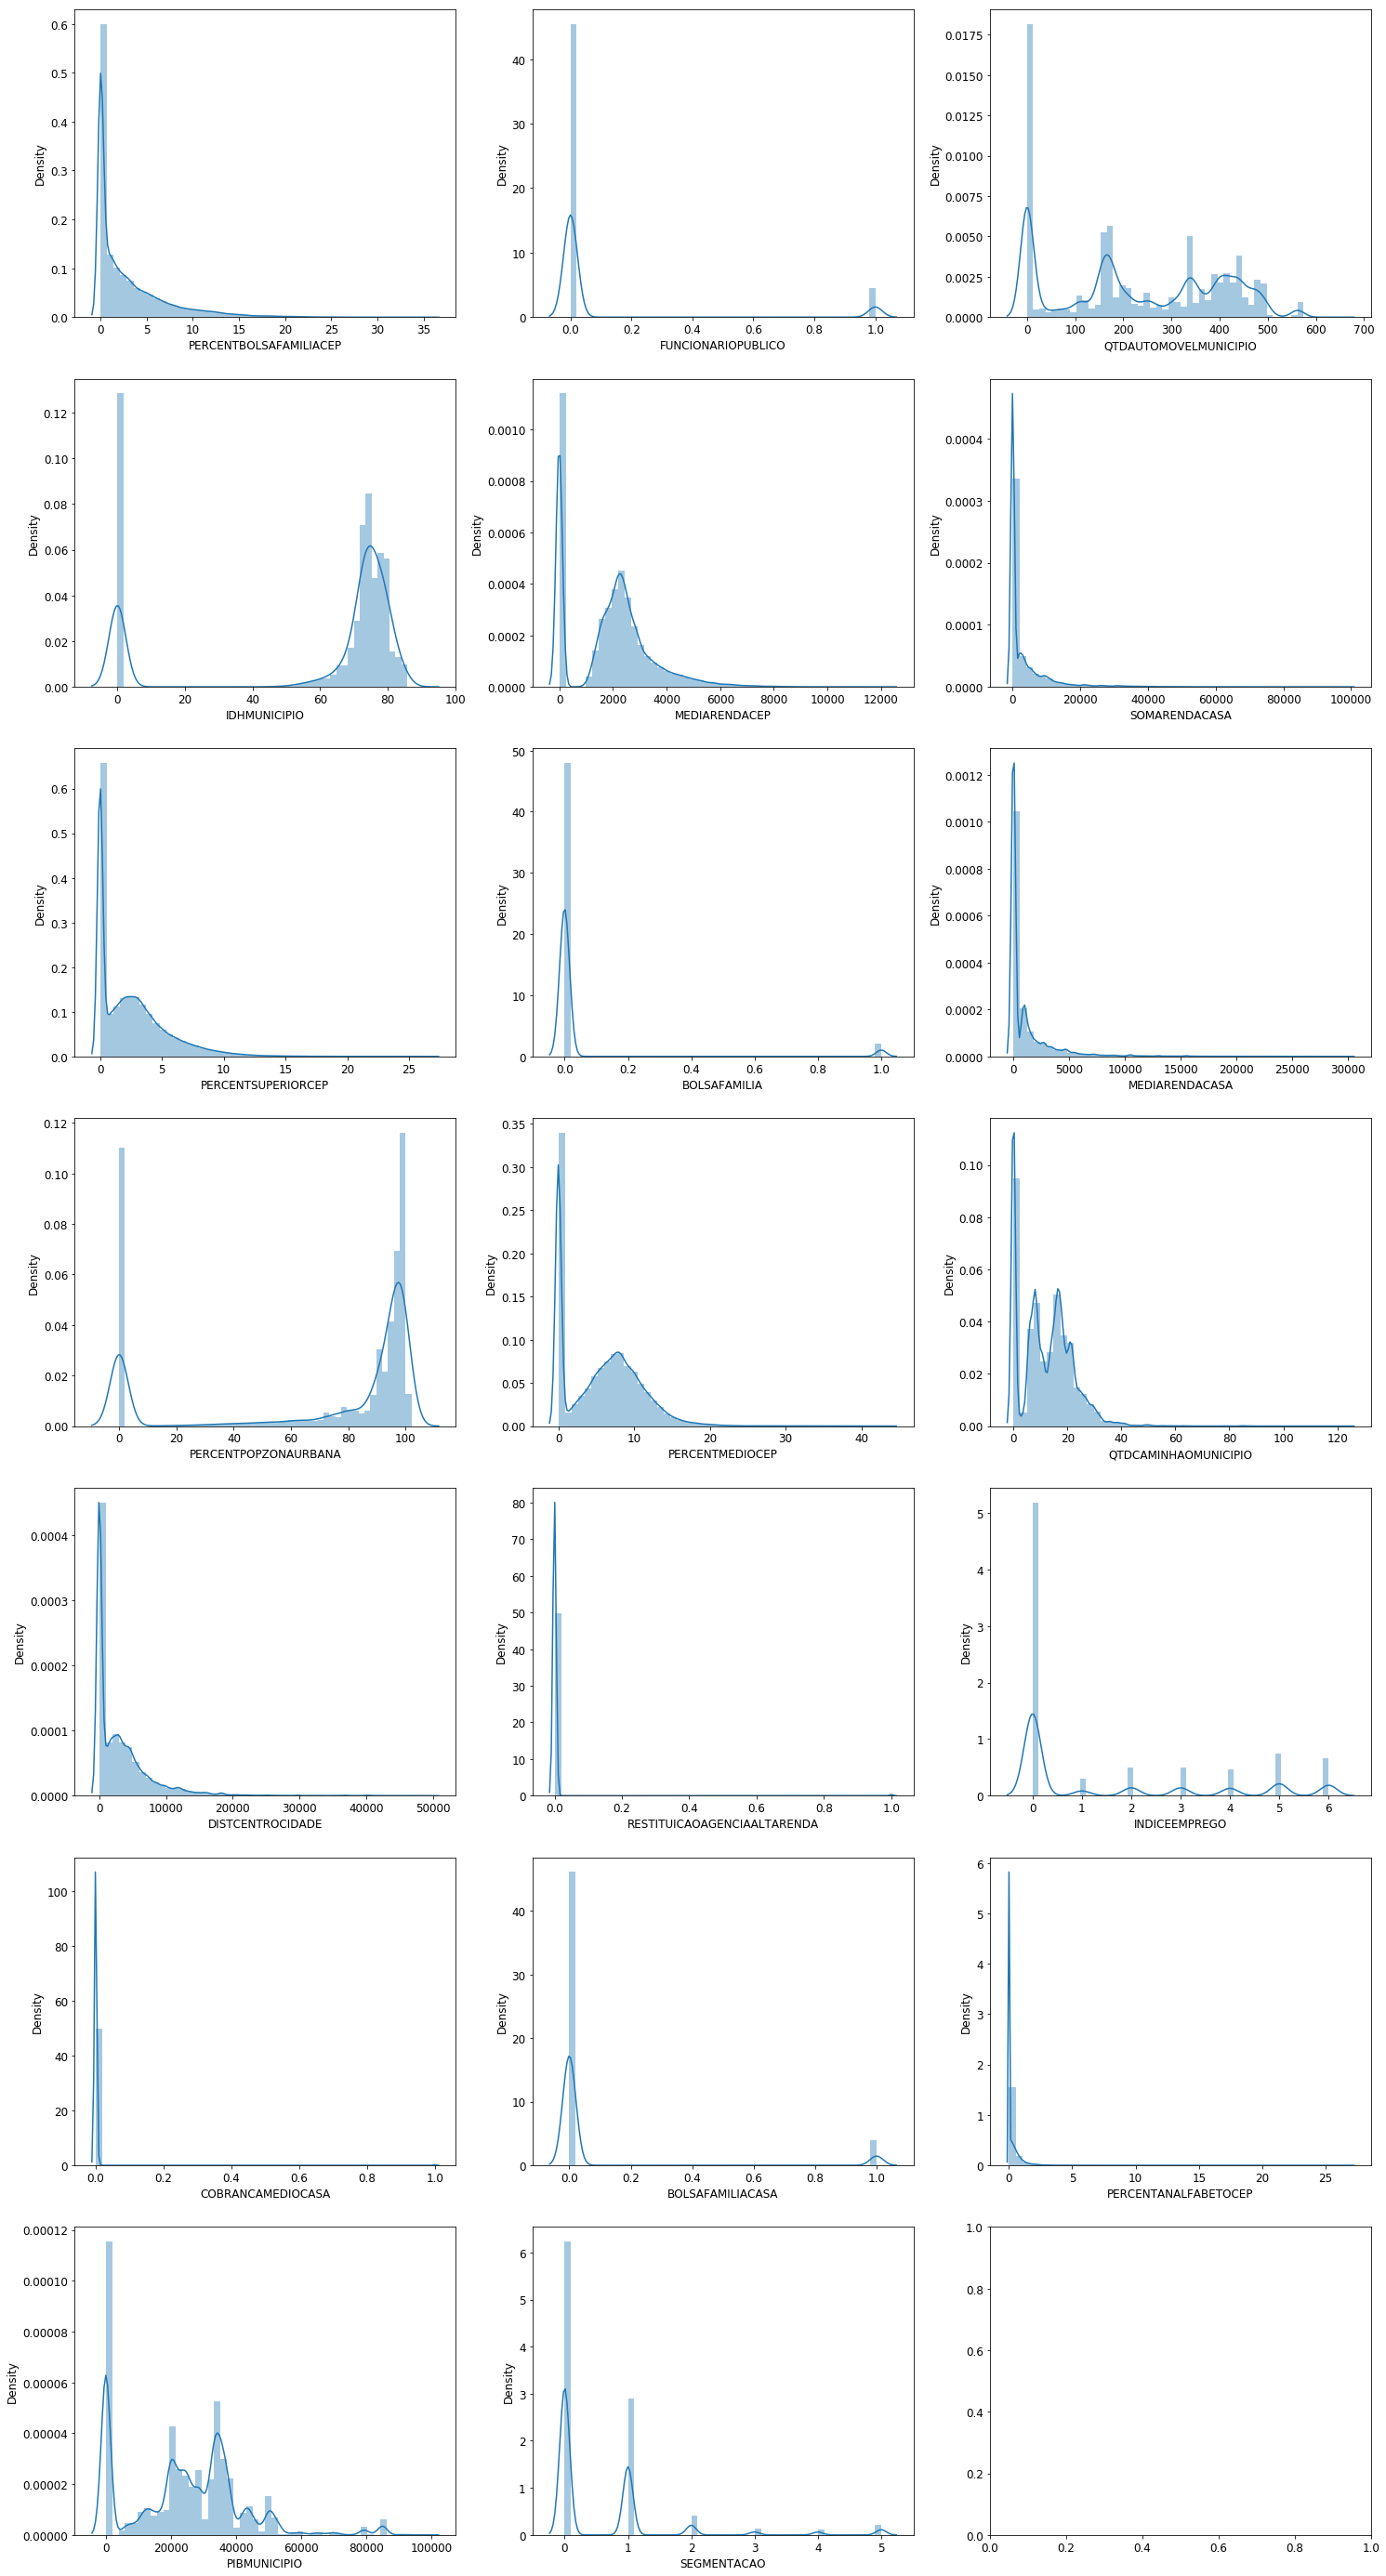

----------------------------------------------------------------------


In [342]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

most_interesting_variables = ['PERCENTBOLSAFAMILIACEP', 'FUNCIONARIOPUBLICO', 
                               'QTDAUTOMOVELMUNICIPIO', 'IDHMUNICIPIO',
                               'MEDIARENDACEP', 'SOMARENDACASA', 'PERCENTSUPERIORCEP',
                               'BOLSAFAMILIA', 'MEDIARENDACASA', 'PERCENTPOPZONAURBANA',
                               'PERCENTMEDIOCEP', 'QTDCAMINHAOMUNICIPIO', 'DISTCENTROCIDADE',
                                'RESTITUICAOAGENCIAALTARENDA', 'INDICEEMPREGO','COBRANCAMEDIOCASA',
                                'BOLSAFAMILIACASA', 'PERCENTANALFABETOCEP', 'PIBMUNICIPIO',
                                'SEGMENTACAO']


print("DISTRIBUIÇÃO")

fig, ax = plt.subplots(7,3,figsize=(25,50))
for variable, i in zip(most_interesting_variables, range(len(most_interesting_variables))):
  sns.distplot(df[variable], ax=ax[i//3][i%3])
plt.show()

print("----------------------------------------------------------------------")

## Análise da distribuição

### PERCENTBOLSAFAMILIACEP
Tem um comportamento semelhante ao de uma gaussiana, porém um pico próximo ao valor 5 parece quebrar esse padrão

### FUNCIONARIOPUBLICO
Seu comportamento não se assemelha ao de uma gaussiana, pois há dois picos em lados opostos do gráfico

### QTDAUTOMOVELMUNICIPIO
Esse gráfico segue uma tendência ascendente e depois descendente, porém há vários picos que fogem do padrão gaussiano

### IDHMUNICIPIO
Esse gráfico mostra um padrão mais semelhante a uma gaussiana do que os anteriores, pois há um pico bem definido, seguido de valores menores tanto para a direita quando para a esquerda, apesar de pequenos picos à direita

### MEDIARENDACEP
Apresenta um padrão gaussiano semelhante ao do IDHMUNICIPIO, e sem picos menores

### SOMARENDACASA
Há uma constante oscilação de frequências, porém ainda pode ser considerado gaussiano

### PERCENTSUPERIORCEP
Muito semelhante a um gráfico gaussiano de assimetria positiva

### BOLSAFAMILIA
Por apresentar apenar dois valores diferentes, não há como classificá-lo como gaussiano

### MEDIARENDACASA
Assemelha-se a um gráfico gaussiano de assimetria levemente negativa

### PERCENTPOPZONAURBANA
Assim como o anterior, apresenta um padrão gaussiano assimétrico levemente negativo

### PERCENTMEDIOCEP
Apresenta uma distribuição gaussiana neutra

### QTDCAMINHAOMUNICIPIO
Apresenta dois picos separados, porém se o pico maior for desconsiderado, pelo fato de seus valores serem a média dos dados, portanto tendo uma grande concentração de valores iguais, a distribuição poderia ser considerada como gaussiana

### DISTCENTROCIDADE
Apresenta uma distribuição gaussiana de assimetria positiva

### RESTITUICAOAGENCIAALTARENDA
Não há simetria e não há como dizer se é uma gaussiana por poucos dados existentes

### INDICEEMPREGO
Tem um pico no começo, mas com crescentes e decrescentes, tendo um formato parecido com uma periódica

### COBRANCAMEDIOCASA
Como no caso da RESTITUICAOAGENCIAALTARENDA, não tem uma simetria e não ha como dizer se é uma gaussiana por poucos dados existentes

### BOLSAFAMILIACASA
Como no caso da BOLSAFAMILIA, apresenta apenas dois valores, não tendo como classificá-lo como gaussiano

### PERCENTANALFABETOCEP
Não há como classificá-lo como gaussiano, inexistencia de simetria, apenas uma curva descendente

### PIBMUNICIPIO
Pode ser considerada uma gaussiana, apresenta um gradne pico inicial, com certas variações

### SEGMENTACAO
Não apresenta formato gaussiano, tendo vários picos pelo gráfico, parecendo uma periódica.

### Considerações
Todos os gráficos apresentam um grande pico que parece estar fora do padrão. Isso ocorre porque os valores faltantes foram substituídos pela média dos valores, fazendo com que muitos itens tenham o mesmo valor


## plotagem da Media, Desvio padrão, Curtose e Pearson (Skew)

In [343]:
print("MEDIA\n")
for variable in most_interesting_variables:
  print(variable+" = ",df[variable].mean())

print("----------------------------------------------------------------------")

print("DESVIO PADRAO\n")
for variable in most_interesting_variables:
  print(variable+" = ",df[variable].std())
print("----------------------------------------------------------------------")

print("CURTOSE\n")
for variable in most_interesting_variables:
  print(variable+" = ",df[variable].kurtosis())
print("----------------------------------------------------------------------")


print("Skew (Pearson)\n")
for variable in most_interesting_variables:
  print(variable+" = ",df[variable].skew())
print("----------------------------------------------------------------------")

MEDIA

PERCENTBOLSAFAMILIACEP =  2.856397952277145
FUNCIONARIOPUBLICO =  0.09037216854806432
QTDAUTOMOVELMUNICIPIO =  228.50072938248906
IDHMUNICIPIO =  57.89320841119919
MEDIARENDACEP =  1901.4918708083
SOMARENDACASA =  3133.688595344994
PERCENTSUPERIORCEP =  2.4937327523416095
BOLSAFAMILIA =  0.040877689086158145
MEDIARENDACASA =  1094.483511444903
PERCENTPOPZONAURBANA =  70.36275075037022
PERCENTMEDIOCEP =  5.720633066816913
QTDCAMINHAOMUNICIPIO =  11.979406678077623
DISTCENTROCIDADE =  3131.282365031157
RESTITUICAOAGENCIAALTARENDA =  0.0037486943024402307
INDICEEMPREGO =  1.4751925598831137
COBRANCAMEDIOCASA =  0.0020923701705460665
BOLSAFAMILIACASA =  0.07773984972682041
PERCENTANALFABETOCEP =  0.23961796329798968
PIBMUNICIPIO =  24128.94587968343
SEGMENTACAO =  0.5683795032329234
----------------------------------------------------------------------
DESVIO PADRAO

PERCENTBOLSAFAMILIACEP =  3.8953937177792866
FUNCIONARIOPUBLICO =  0.2867146790839504
QTDAUTOMOVELMUNICIPIO =  171.37

# Multivariate data analysis

In this section, you should plot at least 8 multivariate visualizations. The key here is to investigate underlying correlations and behaviors in the dataset.
Naturally, as visualizations are being created, we should end up with obvious results, yet, you should find at least **TWO** non-obvious behavior in data.

Please follow these steps for creating your visualizations:
1. State an hypothesis. The key here is to explain why you are choosing those specific variables together and what you are expecting to find.
2. Determine what kind of visualization is the most suited.
3. Report the findings and whether they corroborate or not the aforestated hypothesis.


### Hints

In this section, make sure you go beyond naive explorations. For instance, try PCA, t-SNE, and even other techniques we have not worked with during the lectures. The key here is to start to develop a critical mindset towards data analysis and our own work.

### Important

It is strictly forbidden to create multivariate visualizations using variables that were not used in the previous section (univariate analysis).

### Heatmap - Matriz de correlações

D:\Usuario\Anaconda3_2\envs\lixoLearning\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


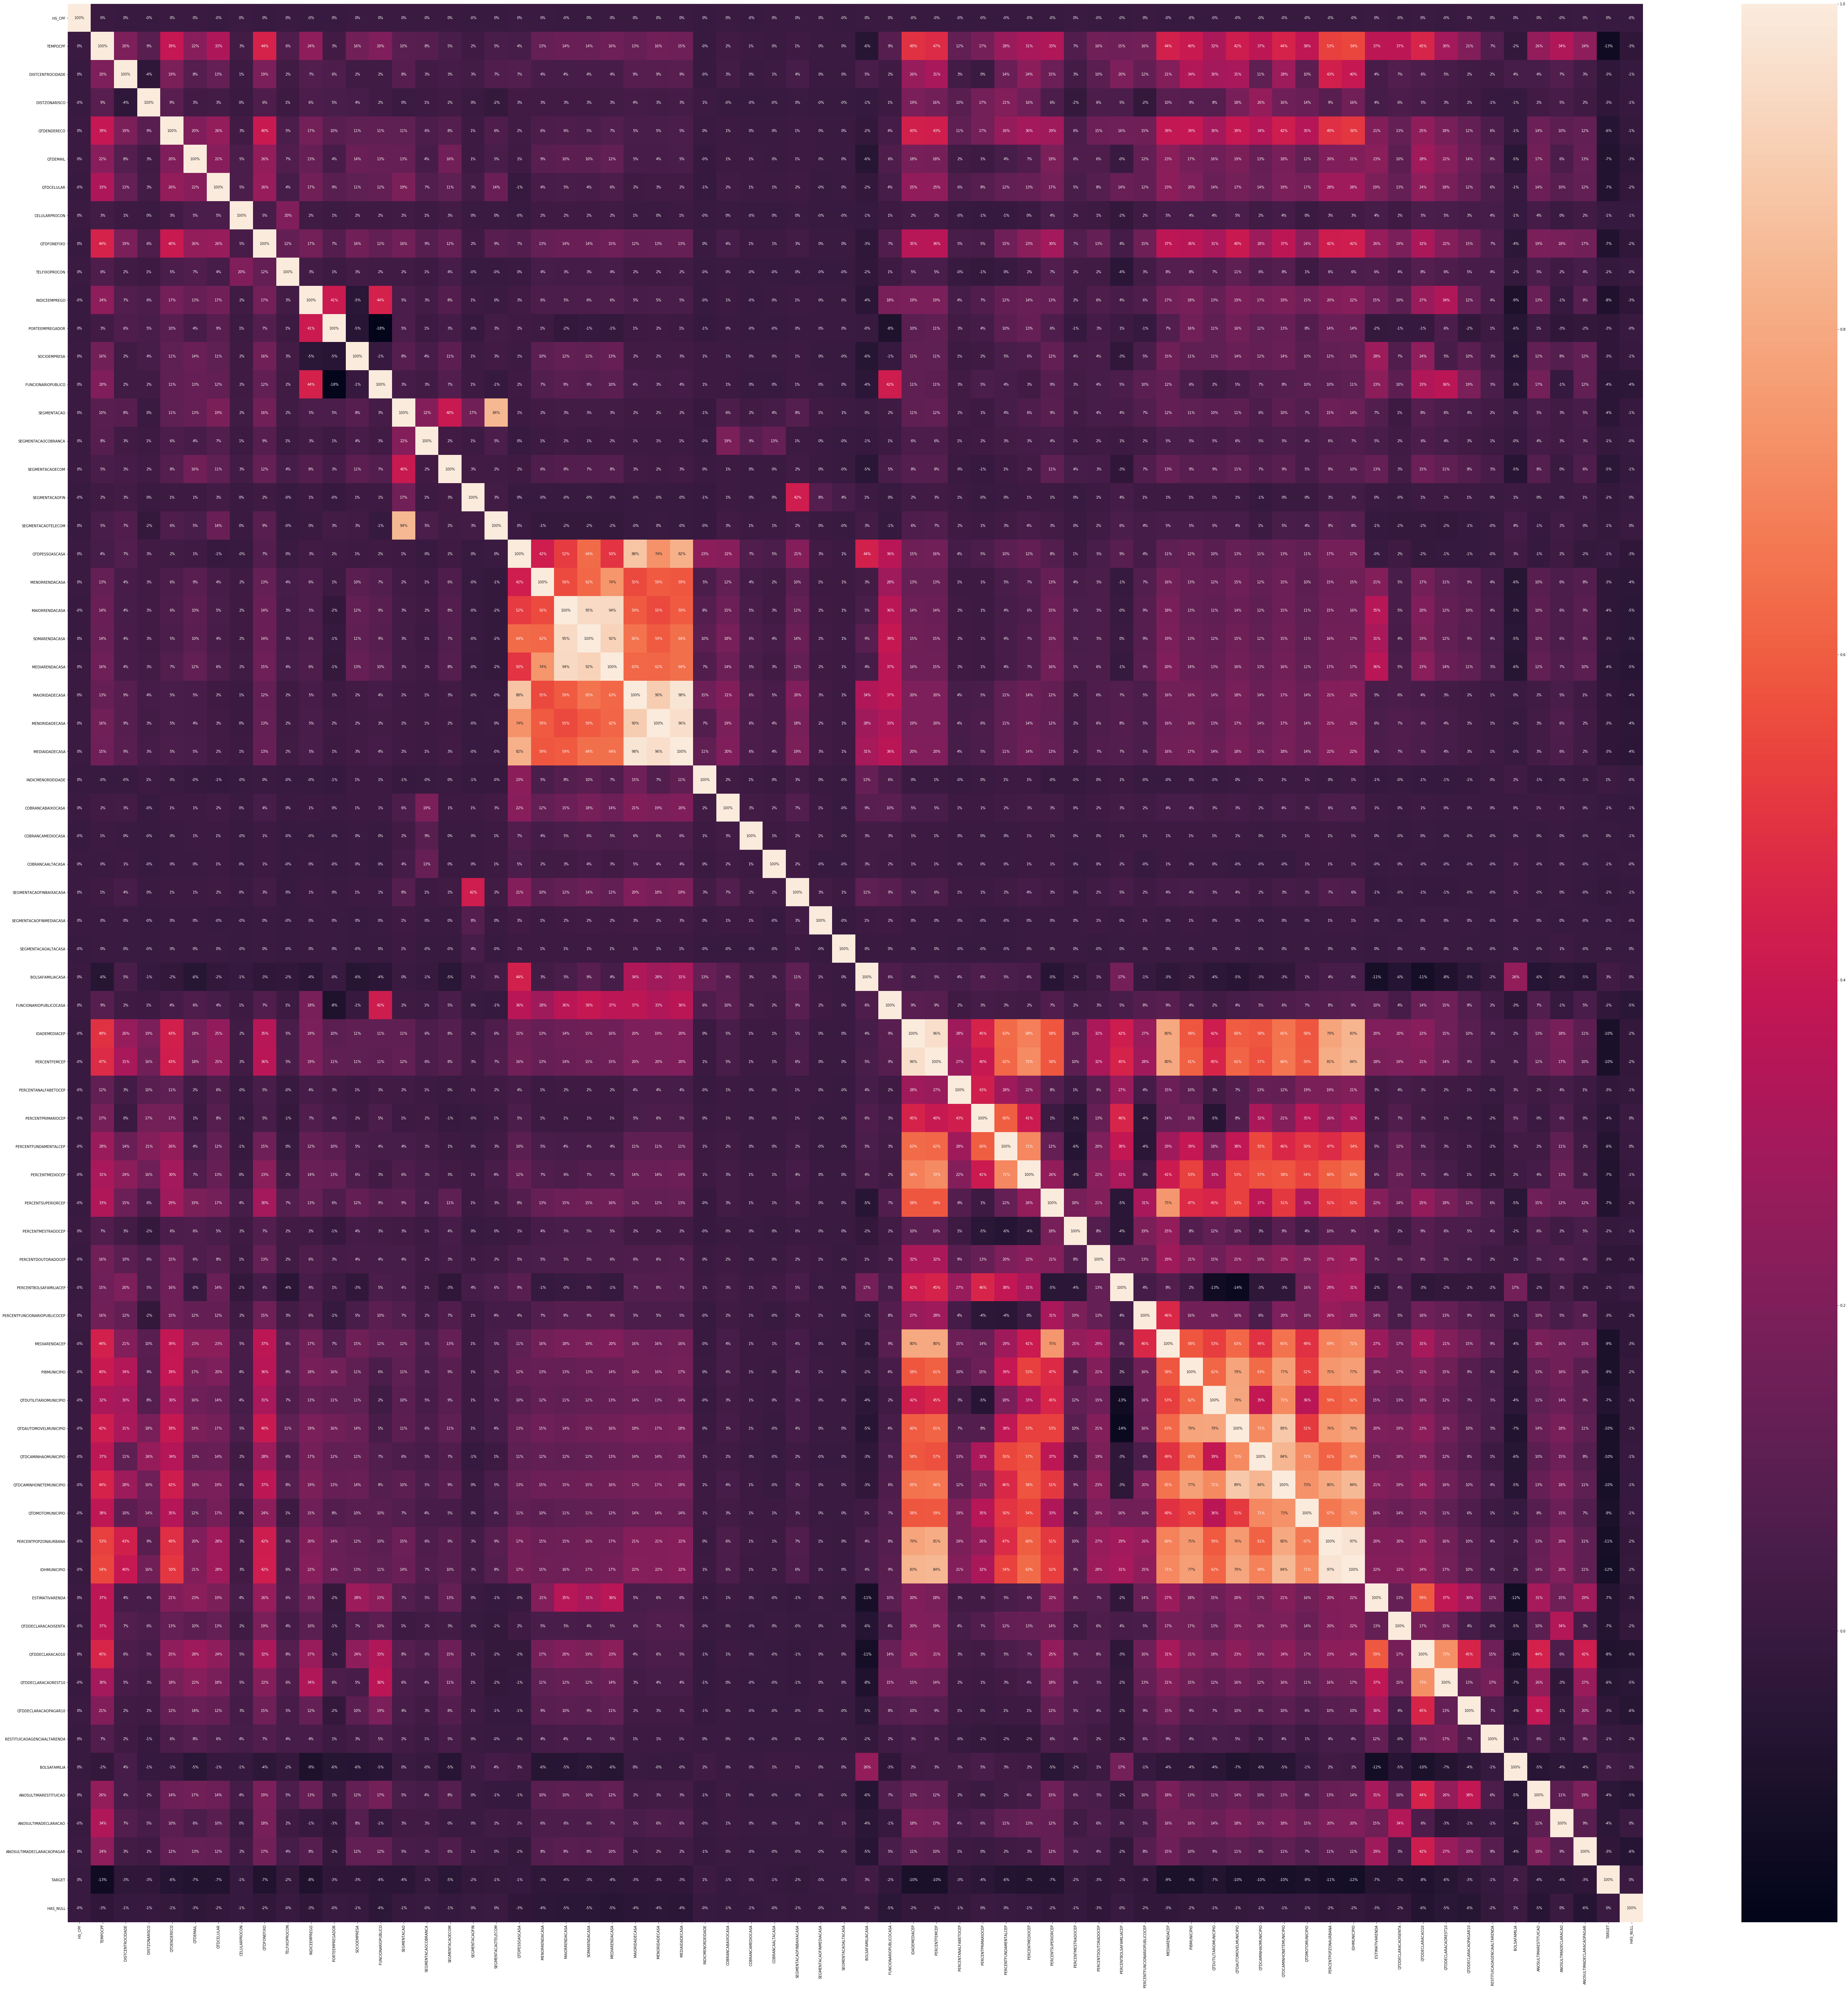

In [344]:
#vif# clean and treat the data here
plt.rcParams['figure.figsize'] = (100, 100)
plt.rcParams['font.size'] = 10

cor = df.corr()
sns.heatmap(cor, annot=True, fmt='.0%')
plt.show()

### Variance Inflation Factor
Analisando o peso das variáveis no dataset

In [345]:
def calc_vif(tabela):
  vif = pd.DataFrame()
  vif['variaveis'] = tabela.columns
  vif['vif'] = [variance_inflation_factor(tabela.values, i) for i in range(tabela.shape[1])]

  return vif

In [346]:
pd.options.display.max_rows = 70

In [347]:
vif = calc_vif(df)
vif

,variaveis,vif
0,HS_CPF,3.475030
1,TEMPOCPF,9.534317
2,DISTCENTROCIDADE,2.089661
3,DISTZONARISCO,1.350580
4,QTDENDERECO,3.215607
5,QTDEMAIL,1.907158
6,QTDCELULAR,2.202303
7,CELULARPROCON,1.051478
8,QTDFONEFIXO,3.073245
9,TELFIXOPROCON,1.081009


## 1º Hipótese (não óbvia):
 As pessoas que são beneficiadas pelo bolsa família tendem a ter menos veículos
 
 (não obvia): consideramos essa hipótese não obvia porquê só conseguimos chegar nessa hipótese analisando as correlações do heatmap

D:\Usuario\Anaconda3_2\envs\lixoLearning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[(0, 669.0951931451577)]

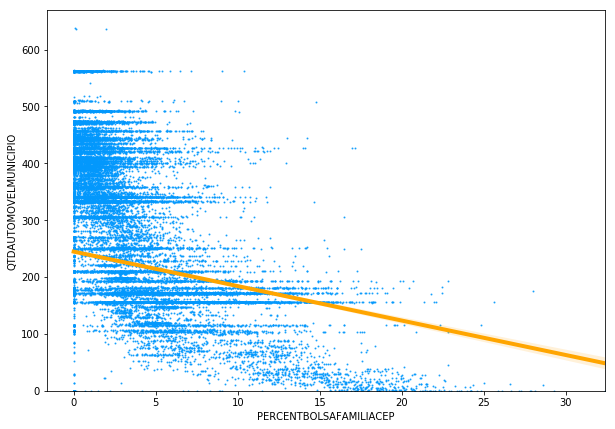

In [348]:
#NON OBVIOUS 
plt.figure(figsize=(10, 7))
df_sample = df.sample(30000)

sns.regplot(df_sample['PERCENTBOLSAFAMILIACEP'],df_sample['QTDAUTOMOVELMUNICIPIO'],scatter_kws={'s':1, 'color':'#0398fc'}, line_kws={"color": "orange","lw":4}).set(ylim=(0))

### Resultado

A hipótese provou-se verdadeira, pois a quantidade de automóveis por município mostrou-se maior em regiões em que a taxa de beneficiários pelo bolsa família é abaixo de 5%.

## 2º hipótese (óbvia)
Quanto mais alto o Índice de desenvolvimento humano de um municipio, maior tende a ser a quantidade de carros presentes nele.

[(0, 670.8962258069549)]

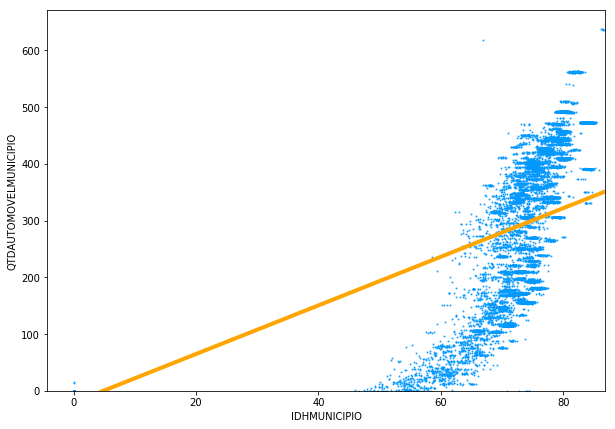

In [349]:
#OBVIOUS
plt.figure(figsize=(10, 7))
df_sample = df.sample(20000)

sns.regplot(df_sample['IDHMUNICIPIO'], df_sample['QTDAUTOMOVELMUNICIPIO'],scatter_kws={'s':1, 'color':'#0398fc'}, line_kws={"color": "orange","lw":4}).set(ylim=(0))

### Resultado

A quantidade de automóveis no município cresce linearmente em relação ao idh do município.

## Hipótese 3 (óbvia)
Quanto mais alto o Índice de Desenvolvimento Humano de um município, menor é o percentual de usuários do bolsa família por região.

[(0, 37.48768367767979)]

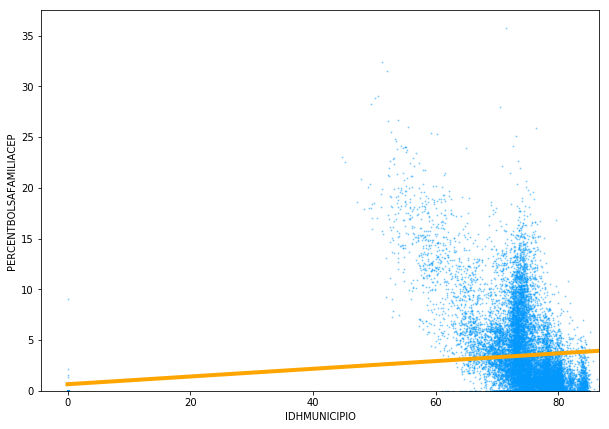

In [350]:
plt.figure(figsize=(10, 7))
df_sample = df.sample(20000)

sns.regplot(df_sample['IDHMUNICIPIO'], df_sample['PERCENTBOLSAFAMILIACEP'],scatter_kws={'s':1, 'color':'#0398fc', "alpha":0.35}, line_kws={"color": "orange","lw":4}).set(ylim=(0))














































### Resultado
A hipótese se provou verdadeira, uma vez que o gráfico demonstra um acúmulo grande nas regiões com alto IDH e baixa porcentagem de beneficários do bolsa familia (eixo y de 0% à 10%), acumulo que diminuíndo de acordo com o percentual de beneficiários.

## 4º hipótese (óbvia)
Regiões com menor escolaridade superior possuem uma renda média menor.

[(0, 21.66754181328879)]

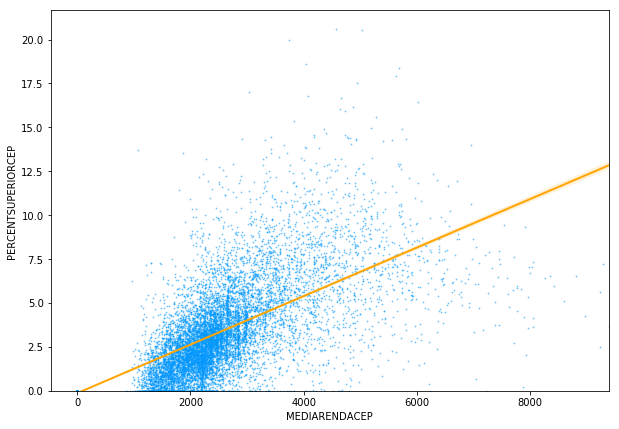

In [351]:
plt.figure(figsize=(10, 7))
df_sample = df.sample(15000)

sns.regplot(df_sample['MEDIARENDACEP'], df_sample['PERCENTSUPERIORCEP'],scatter_kws={'s':0.7, 'color':'#0398fc', "alpha":0.45}, line_kws={"color": "orange","lw":2}).set(ylim=(0))

## 5º hipótese (óbvia)
De acordo com a utilização do bolsa familia, a concentração de pessoas com renda baixa está localizado longe da cidade

[(0, 12.48780742315741)]

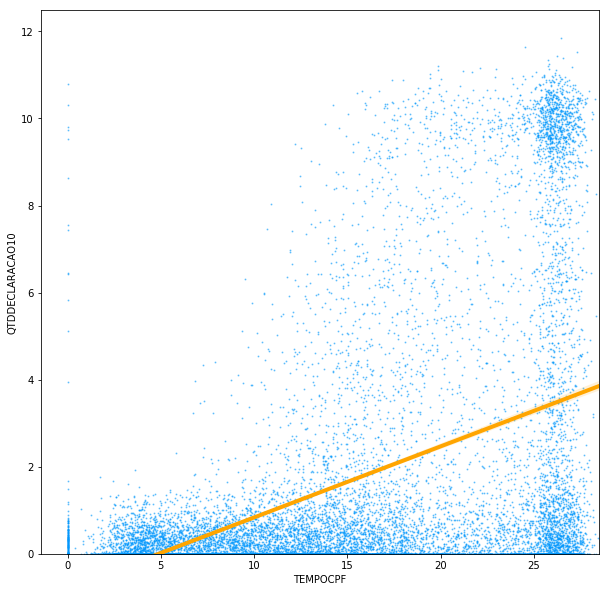

In [352]:
fig, ax = plt.subplots(figsize=(10,10))
'''
SemBolsa=df[df['BOLSAFAMILIA'] == 0]
ComBolsa=df[df['BOLSAFAMILIA'] == 1]

#sns.scatterplot(SemBolsa['DISTCENTROCIDADE'], SemBolsa['MEDIARENDACASA'], label = "Sem bolsa",alpha=0.50,s=15)
sns.scatterplot(ComBolsa['DISTCENTROCIDADE'],ComBolsa['MEDIARENDACASA'], label = "Com bolsa",alpha=0.50,s=15)
'''

sns.regplot(df_sample['TEMPOCPF'], df_sample['QTDDECLARACAO10'],scatter_kws={'s':1, 'color':'#0398fc', "alpha":0.45}, line_kws={"color": "orange","lw":4}).set(ylim=(0))


### Resultado:

A hipótese mostrou-se falsa, visto que os grupos que utilizam bolsa família encotram-se em maior número próximos ao centro da cidade, com uma renda baixa.

## 6º hipótese (obvia)
Quanto maior o percentual de pessoas com ensino médio completo em uma região, maior será a renda dessa região.

[(0, 39.928701871074786)]

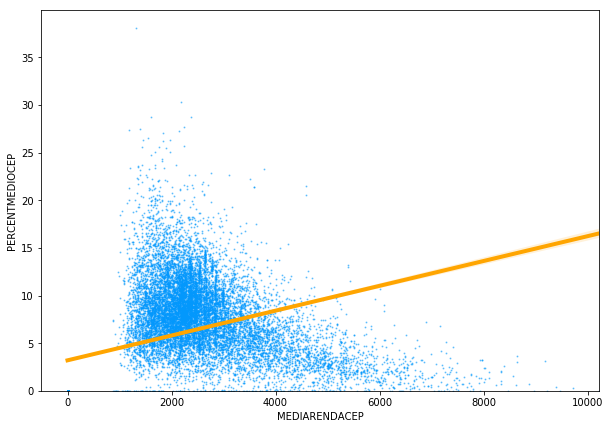

In [353]:

#inutil
plt.figure(figsize=(10, 7))
df_sample = df.sample(20000)
sns.regplot(df_sample['MEDIARENDACEP'], df_sample['PERCENTMEDIOCEP'],scatter_kws={'s':1, 'color':'#0398fc', "alpha":0.45}, line_kws={"color": "orange","lw":4}).set(ylim=(0))
# pessoas com menor renda tendem a ficar mais próximas a zonas de risco

### Resultado
A hipótese se mostrou falsa, pois podemos ver que a linha de regressão plotada demonstra um aumento da renda média de acordo com a diminuição do percentual de pessoas com ensino médio, o que vai totalmente contra a hipótese.

## 7º hipótese (obvia)
Quanto mais proximo do centro da cidade, maior será o percentual de pessoas com ensino superior.

[(0, 21.718306056448753)]

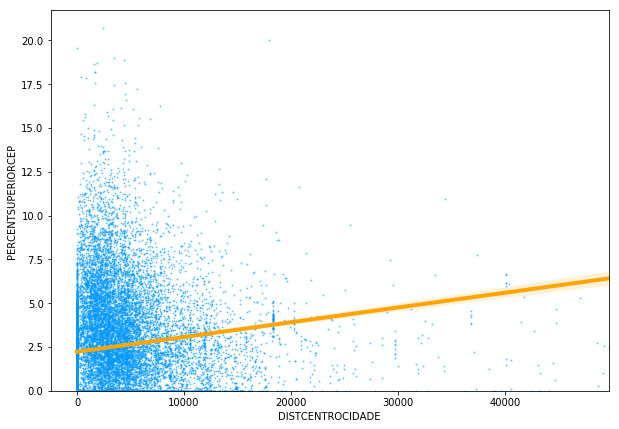

In [354]:

plt.figure(figsize=(10, 7))
df_sample = df.sample(20000)

sns.regplot(df_sample['DISTCENTROCIDADE'], df_sample['PERCENTSUPERIORCEP'],scatter_kws={'s':1, 'color':'#0398fc', "alpha":0.45}, line_kws={"color": "orange","lw":4}).set(ylim=(0))


## Resultado
a hipótese mostrou-se verdadeira, pois possui um maior percentual de ensino superior em regiões próximas ao centro. A linha de regressão demonstra uma tendencia inversamente proporcinal de quem tem ensino superior em relação a sua distância até o centro da cidade.

## 8º hipótese (Não obvia)
Quanto maior o percentual de usuário do bolsa família em uma região, menor é a quantidade de caminhões do município da respectiva região.

[(0, 89.27629595188345)]

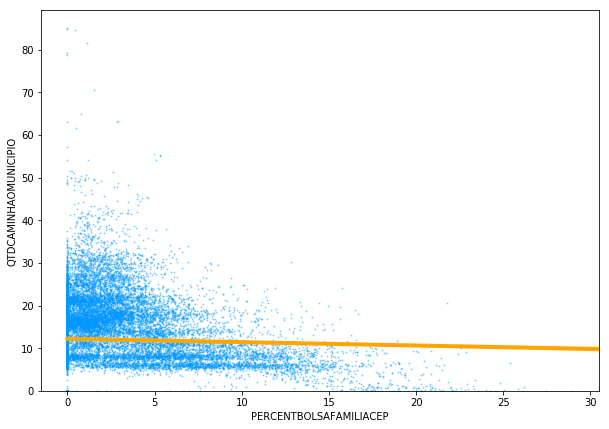

In [355]:
plt.figure(figsize=(10, 7))
df_sample = df.sample(20000)

sns.regplot(df_sample['PERCENTBOLSAFAMILIACEP'], df_sample['QTDCAMINHAOMUNICIPIO'],scatter_kws={'s':1, 'color':'#0398fc', "alpha":0.35}, line_kws={"color": "orange","lw":4}).set(ylim=(0))

### Resultado
a hipótese se mostrou verdadeira, uma vez que a linha de regressão demonstra uma tendencia inversamente proporcinal de quem é beneficiário do bolsa família em relação a quantidade de caminhões da sua cidade.

# Final Plots

In this section, you need to enhance 3 multivariate visualizations that were presented in the previous section of the report.
The key here is to enhance these visualizations with the goal of presenting them for an audience that is not familiar with the dataset used or with data analysis.
**Therefore, make sure that its size, colors, textures, etc, are appropriate are convey the right information to the audience.**

For your final plots, make sure you follow these steps:
1. Present the plot
2. Provide a description of the visualization, including the main findings that we can extract from it


**Hint: take a look at the checklist also made available based on the work of Evergreen.**

# Gráfico 1 - hipótese 5 (bolsa família, distância centro cidade, média renda casa) 

De acordo com a utilização do bolsa familia, a concentração de pessoas com renda baixa está localizado longe da cidade

  valores    medias
0   15-21  1.862750
1     22+  3.523450
2    8-14  0.555361
3     0-7  0.218060


Text(0.5, 0.98, '')

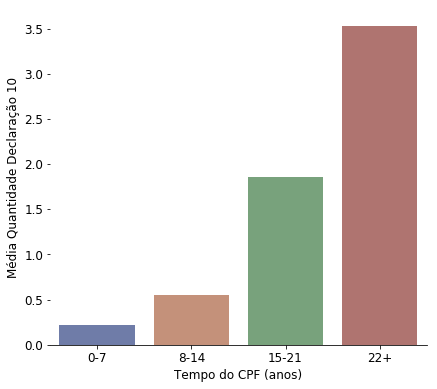

In [356]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

def generate_interval(row):
  if row['TEMPOCPF'] <= 7:
    return '0-7'
  elif  row['TEMPOCPF'] <= 14:
    return "8-14"
  elif row['TEMPOCPF'] <= 21:
    return "15-21"
  return "22+"

df['TCPF_interval'] = df.apply(lambda row: generate_interval(row), axis=1)
valores = df['TCPF_interval'].unique()
medias = []
for valor in valores:
  medias.append(df[df['TCPF_interval'] == valor]['QTDDECLARACAO10'].mean())

toplot = pd.DataFrame()
toplot['valores'] = valores
toplot['medias'] = medias
print(toplot.head())

g = sns.catplot(data=toplot,
    x='valores', y= 'medias', kind='bar',
    ci="sd", palette="dark", alpha=.6, height=6, order=["0-7", "8-14", "15-21", "22+"]
)
g.despine(left=True)
g.set_axis_labels("Tempo do CPF (anos)", "Média Quantidade Declaração 10")

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('', fontsize=16)

# remover media da renda e trocar por count, para mostrar a concentracao de pessoas do bolsa familia no centro

# Gráfico 2 - hipótese 3

Text(0.5, 0.98, 'Percentual de bolsa família no CEP \n com base no IDH do município')

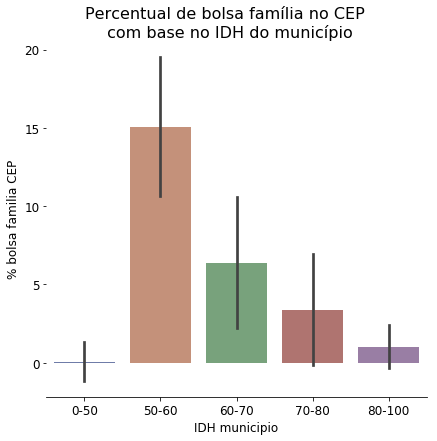

In [357]:
def generate_interval_idh(row):
  if row['IDHMUNICIPIO'] <= 50:
    return '0-50'
  elif  50 < row['IDHMUNICIPIO'] <= 60:
    return "50-60"
  elif 60 < row['IDHMUNICIPIO'] <= 70:
    return "60-70"
  elif 70 < row['IDHMUNICIPIO'] <= 80:
    return "70-80"
  return "80-100"

df['IDH_MUN_interval'] = df.apply(lambda row: generate_interval_idh(row), axis=1)


g = sns.catplot(
    data=df, kind="bar",
    x="IDH_MUN_interval", y="PERCENTBOLSAFAMILIACEP",
    ci="sd", palette="dark", alpha=.6, height=6,order=['0-50', '50-60', '60-70', '70-80', '80-100']
)
g.despine(left=True)
g.set_axis_labels("IDH municipio", "% bolsa familia CEP")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentual de bolsa família no CEP \n com base no IDH do município', fontsize=16)

# Gráfico 3 - hipótese 1

Text(0.5, 0.98, 'Percentual de pessoas que utilizam do bolsa familia\n e  possuem automóvel ')

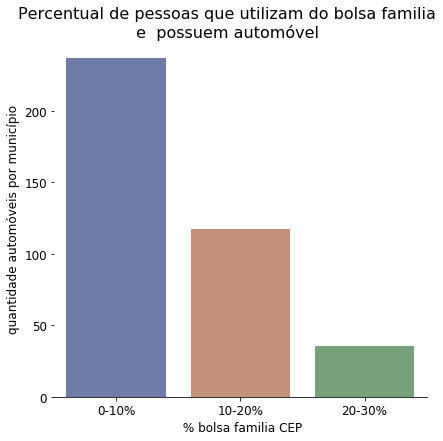

In [358]:
def generate_interval_pbfc(row):
  if row['PERCENTBOLSAFAMILIACEP'] <= 10:
    return '0-10%'
  elif  10 < row['PERCENTBOLSAFAMILIACEP'] <= 20:
    return "10-20%"
  elif 20 < row['PERCENTBOLSAFAMILIACEP'] <= 30:
    return "20-30%"

df['BolsaFamilia_CEP_interval'] = df.apply(lambda row: generate_interval_pbfc(row), axis=1)

df['BolsaFamilia_CEP_interval'].head(5)
g = sns.catplot(
    data=df, kind="bar",
    x="BolsaFamilia_CEP_interval", y="QTDAUTOMOVELMUNICIPIO",
    ci=0.0, palette="dark", alpha=.6, height=6,order=['0-10%', '10-20%', '20-30%']
)
g.despine(left=True)
g.set_axis_labels(" % bolsa familia CEP", "quantidade automóveis por município")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentual de pessoas que utilizam do bolsa familia\n e  possuem automóvel ', fontsize=16)
# remover media da renda e trocar por count, para mostrar a concentracao de pessoas do bolsa familia no centro



In [359]:
df['BolsaFamilia_CEP_interval'].head(5)

0    0-10%
1    0-10%
2    0-10%
3    0-10%
4    0-10%
Name: BolsaFamilia_CEP_interval, dtype: object

# Digest

In this section you should write down all the main findings of this exploratory data analysis. Furthermore, you should provide a reflection about your own work and effort during the module, highlighting what you believe you have done well and what you should have done differently. This digest should have at least 2500 characters (no spaces).

Primeiramente, procuramos saber qual a distribuição da classe do dataset, ou seja, saber se há mais inadimplentes ou mais adimplentes na base, e foi descoberto que há uma grande diferença na quantidade de valores, com a maioria das instâncias sendo de bons pagadores. Também fizemos uma análise de 28 variáveis, escolhendo as 20 mais interessantes para serem analisadas e usadas durante o trabalho, podendo observar nelas a média, desvio padrão, curtose e Pearson, o que nos ajudou a termos uma observação melhor sobre o que deveríamos fazer mais para frente. Toda essa análise foi feita tendo em mente como os modelos de Machine Learning irão performar, ou seja, buscamos identificar o máximo de poluição de dados, remover o máximo possível de fatores aleatórios ou não relacionados ao TARGET, como pode ser observado na coluna HS_CPF, onde os valores da hash de um CPF podem dar a falsa ilusão de que esse dado é relacionado à inadimplência ou não de uma pessoa.<br>
Outra análise importante nesse processo foi o heatmap, baseado em uma matriz de correlação, na qual foi possível observar correlação fraca entre a maioria dos dados, e algumas correlações fortes, que foram levadas em consideração na análise multivariada. Foi possível observar a correlação entre as variáveis e o peso de cada coluna no dataset, isto sendo analisadas de forma mais profunda com o cálculo do vif, para termos certeza dessas correlações entre outras variáveis. Ainda, analisando os dados, achamos algumas informações, que, para nós, foi interessante e significativo. Dentre elas, as hipóteses que nos ajudaram a melhor interpretar nosso estudo, como a concentração de menor renda é localizada em regiões mais afastadas das cidades, pessoas que tendem a ter o benefício do bolsa família não possuem tantos veículos, por exemplo.<br>
Um dos fatores que poderia ser explorado mais a fundo é a questão de criar novos dados a partir de dados já existentes, a fim de criar uma camada de abstração e simplificação da base de dados, especialmente quando o foco é o resultado do modelo preditivo.<br>
Entre as práticas desenvolvidas pela equipe que consideramos bem-sucedidas, está a utilização do heatmap na matriz de correlação como a principal ferramenta de análise multivariada. A análise desse mapa foi um critério muito relevante no processo de busca por relações entre duas ou mais variáveis, para que mais adiante fossem analisadas mais a fundo. Outra decisão que trouxe bons resultados foi o tratamento de valores nulos. Foram testados três valores diferentes para substituírem os valores nulos: média, mediana e 0, dentre os quais, o número 0 trouxe o maior ganho para o modelo preditivo.<br>
Portanto, consideramos que os pontos benéficos dessa análise de dados foram resultado, em grande parte, da aplicação dos conteúdos vistos em aula, já que foi possível aplicar todas as técnicas vistas ao longo do período e como essa abordagem está presente no mundo real. Combinado a isso, após cada aula, procuramos aplicar o conhecimento adquirido nela nesse estudo para trazer os melhores resultados possíveis.

# Machine Learning

In this section, you should test different machine learning approaches to **build** and **evaluate** your model.

**IMPORTANT: DO NOT FORGET TO REPORT YOUR PREDICTIONS FOR THE TEST DATA. YOU SHOULD BUILD AND EXPORT A FILE ACCORDING TO THE PROJECT DESCRIPTION WITH THE DEFAULTING PROBABILITIES!**

### Exclusão de colunas

Colunas excluídas: foram selecionadas a partir de várias análises de feature relevance. As colunas menos relevantes foram retiradas.

In [360]:
drop_test = ['PERCENTFUNDAMENTALCEP','PERCENTSUPERIORCEP','DISTZONARISCO','ANOSULTIMADECLARACAOPAGAR','MAIORRENDACASA','COBRANCABAIXOCASA', 'SEGMENTACAOFINMEDIACASA','BolsaFamilia_CEP_interval', 'IDH_MUN_interval', 'TCPF_interval', 'HS_CPF', 'PIBMUNICIPIO', 'IDHMUNICIPIO',
             'SOCIOEMPRESA', 'FUNCIONARIOPUBLICO', 'TELFIXOPROCON', 'SEGMENTACAOCOBRANCA', 'CELULARPROCON',
             'RESTITUICAOAGENCIAALTARENDA', 'SEGMENTACAOFIN', 'SEGMENTACAOALTACASA', 'BOLSAFAMILIA', 'BOLSAFAMILIACASA',
             'INDICMENORDEIDADE', 'COBRANCAMEDIOCASA']

drop_test_2 = ['PERCENTFUNDAMENTALCEP','PERCENTSUPERIORCEP','DISTZONARISCO','ANOSULTIMADECLARACAOPAGAR','MAIORRENDACASA','COBRANCABAIXOCASA', 'SEGMENTACAOFINMEDIACASA', 'HS_CPF', 'PIBMUNICIPIO', 'IDHMUNICIPIO',
             'SOCIOEMPRESA', 'FUNCIONARIOPUBLICO', 'TELFIXOPROCON', 'SEGMENTACAOCOBRANCA', 'CELULARPROCON',
             'RESTITUICAOAGENCIAALTARENDA', 'SEGMENTACAOFIN', 'SEGMENTACAOALTACASA', 'BOLSAFAMILIA', 'BOLSAFAMILIACASA',
             'INDICMENORDEIDADE', 'COBRANCAMEDIOCASA']
df.drop(drop_test, axis=1, inplace=True)
df_test.drop(drop_test_2, axis=1, inplace=True)

### Separação do target dos demais dados
Também é feito o cálculo das variáveis com mais peso segundo o SelectKBest

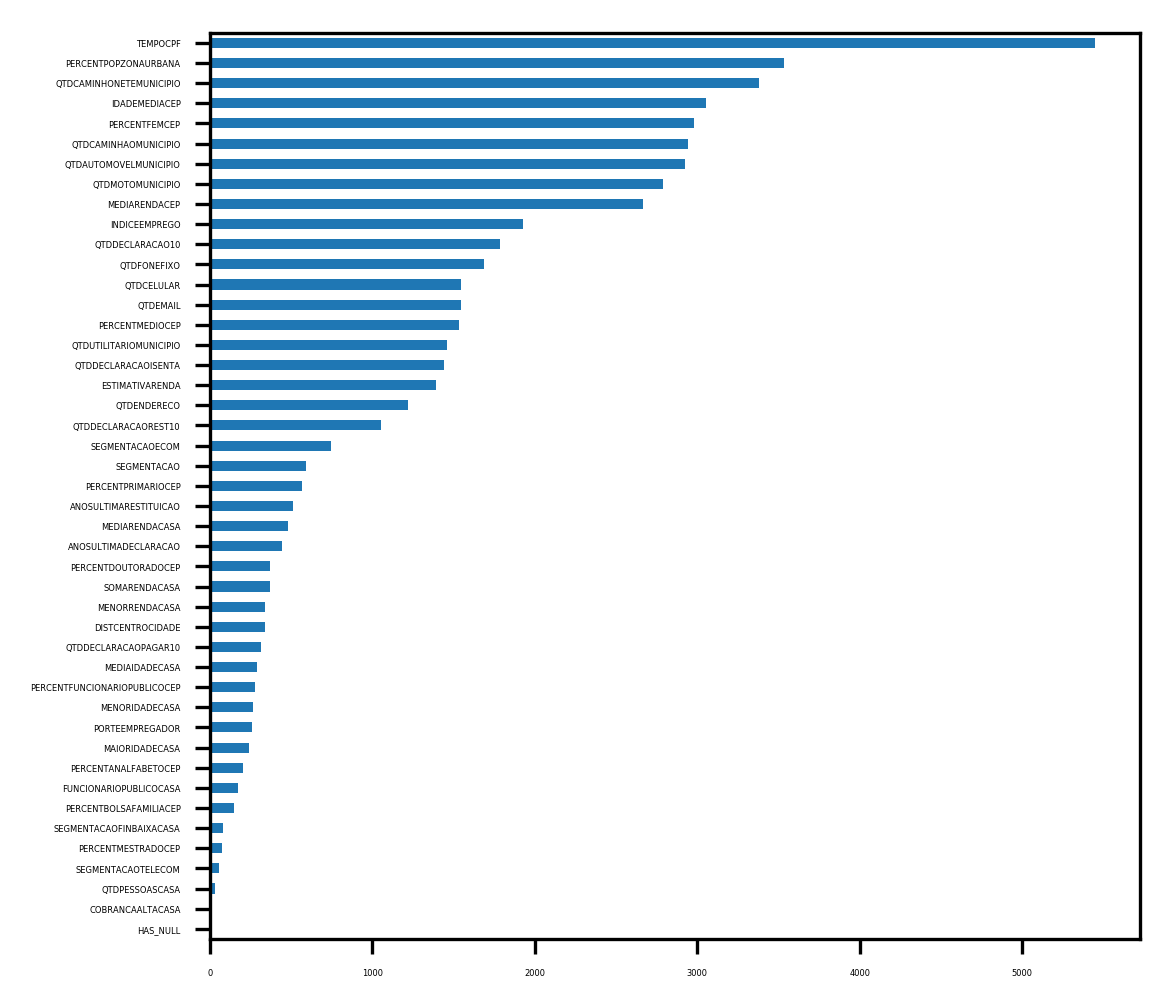

In [361]:
X_pre = df.drop(['TARGET'], axis=1)
y= df['TARGET']
y = df['TARGET'].astype('int32')
skb = SelectKBest(k='all')
skb.fit(X_pre, y)
matplotlib.rc('font', size=2)
fig, ax = plt.subplots(nrows=1, figsize=(4,4),dpi=300)
importances = pd.Series(data=skb.scores_, index=X_pre.columns.values)
importances.sort_values().plot(kind='barh')

In [362]:
def get_best_n_columns(scores, columns, n):
  zipped = dict(zip(scores, columns))
  return list({k: v for k, v in sorted(zipped.items(), key=lambda item: item[1])}.values())[:n]

### Train test split
Separação do conjunto de testes e de treino para obtenção do KS

In [363]:
# # use as many cells as you wish.


#xgb = XGBClassifier(n_estimators=100, learning_rate=0.5)
#xgb.fit(X_pre, y)

X = X_pre #df[get_best_n_columns(xgb.feature_importances_, X_pre.columns.values, 5)]

#X_train = X
#y_train = y
#X_test = df.drop(["TARGET"], axis=1)
#y_test = df["TARGET"].astype('int32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)




In [364]:
print(len(df.columns.values))

46


### Treinamento: XGBoost
Os parâmetros foram calibrados após vários testes

In [365]:
#forest = RandomForestClassifier(n_estimators=100, random_state=0)
#forest.fit(X_train, y_train)
xgb = XGBClassifier(n_estimators=600, learning_rate=0.05, max_depth=3,subsample=0.8,colsample_bytree=0.9,gamma=1)
xgb.fit(X_train, y_train)
#lr = LogisticRegression(random_state=0, max_iter=1000000)
#lr.fit(X_train, y_train)
#knn = KNeighborsClassifier(n_neighbors=3)
#knn.fit(X_train, y_train)
#tree = DecisionTreeClassifier(random_state=0)
#tree.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

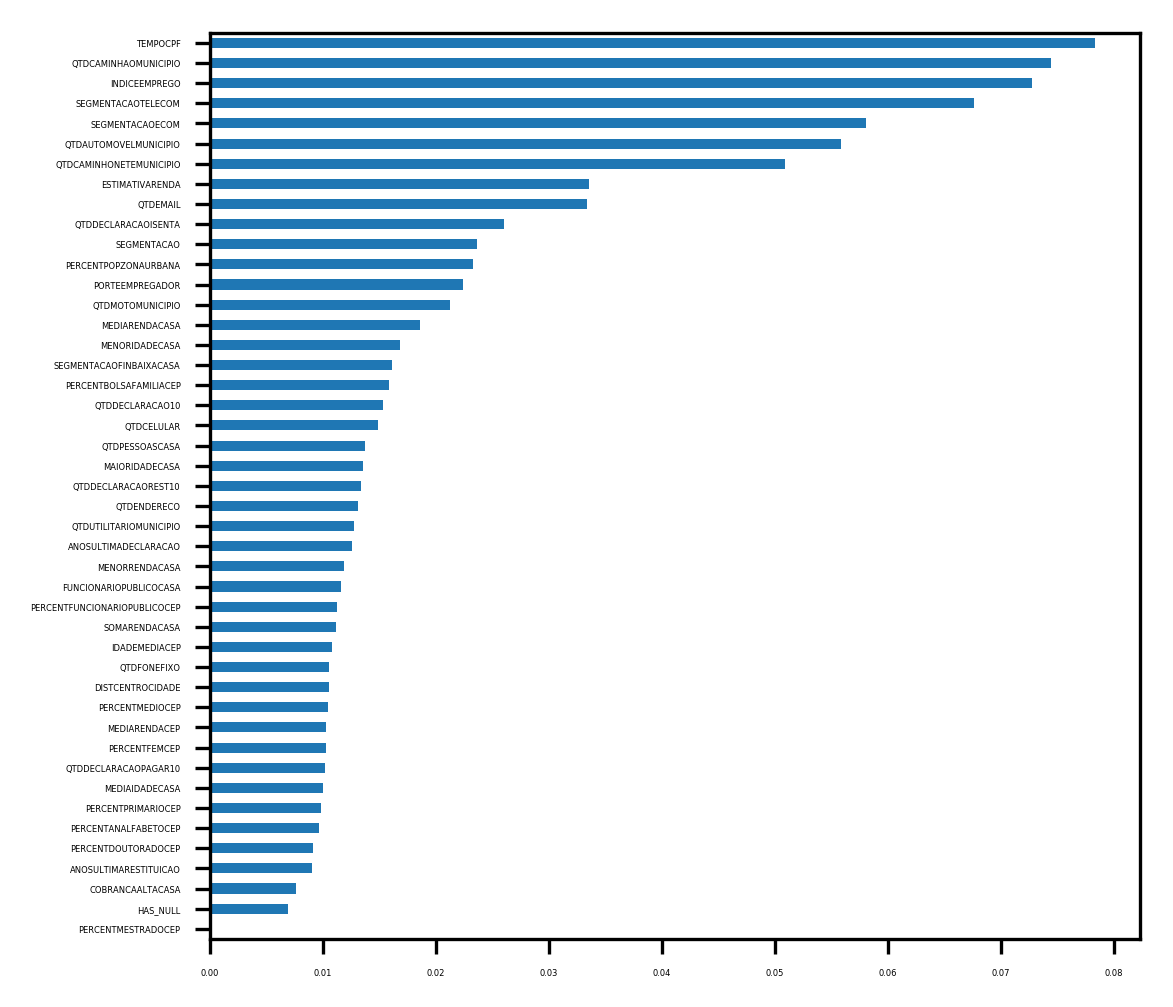

In [366]:
matplotlib.rc('font', size=2)
fig, ax = plt.subplots(nrows=1, figsize=(4,4),dpi=300)

importances = pd.Series(data=xgb.feature_importances_, index=X.columns.values)
importances.sort_values().plot(kind='barh')

### Predições

In [367]:
'''
knn_preds = knn.predict(X_test)
knn_probs = knn.predict_proba(X_test)

forest_preds=forest.predict(X_test)
forest_probs=forest.predict_proba(X_test)


lr_preds=lr.predict(X_test)
lr_probs=lr.predict_proba(X_test)
'''
xgb_preds=xgb.predict(X_test)
xgb_probs=xgb.predict_proba(X_test)


### KS

In [368]:

def computeKS(y_true, y_prob_positive):
  """
  Description:
  Kolmogorov-Smirnov value obtained from ground-truth
  targets (y_true) and
  their probabilities (y_prob_positive).
  Params:
  y_true (pd.Series): Ground-truth labels
  y_prob_positive (pd.Series): The probabilities of
  TARGET=1
  Output:
  ks (float): The KS rate
  """
  vals = list(zip(y_true, y_prob_positive))
  positives = []
  negatives = []
  for a, b in vals:
    if a == 0:
      negatives.append(b)
    else:
      positives.append(b)
  ks = 100.0 * stats.ks_2samp(positives, negatives)[0]
  return ks

#

In [369]:
xgb_probs_true = [x[1] for x in xgb_probs]

computeKS(y_test, xgb_probs_true)

28.61009355019124

### Test set output

In [370]:
xgb_final = XGBClassifier(n_estimators=600, learning_rate=0.05, max_depth=3,subsample=0.8,colsample_bytree=0.9,gamma=1)
xgb_final.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [371]:
xgb_probs=xgb_final.predict_proba(df_test)
xgb_probs_true = [x[1] for x in xgb_probs]

In [372]:
df_output = pd.DataFrame({"Capangas do Andre": xgb_probs_true})
df_output.to_csv("Capangas_do_Andre.csv", index=False)

# Future work

In this cell, please provide at least 3 different ideas that you would like to pursuit within this dataset. That may include, for example, the use of machine learning techniques towards a goal, or analyzing variables that you had no time to during this work. 
Please provide **details** on how you would tackle this problem and provide specifics on which techniques should be used for such purposes.
This section should contain, at least, 2500 characters (no spaces).

Durante o desenvolvimento do trabalho, analisamos várias maneiras de buscar um melhor resultado. Limpamos a base para ter uma melhor visualização, bem como retiramos colunas e dados não relevantes para a condução do trabalho, filtrando valores específicos, como valores negativos, e trocando valores NaN por 0, sendo que, nesses dois últimos casos citados, fizemos uma função extra para filtrar esses valores. Vimos que, durante a remoção de certas colunas, o resultado era afetado, por isso, optamos por manter as colunas com maior impacto em nível de importância quando analisadas para obtenção do KS. O segundo passo foi a escolha do modelo de Machine Learning. Escolhemos 5 diferentes modelos, entre eles: Random Forest, XGBoost, Regressão Logística, KNeighbors e Decision Tree. Após varios testes e treinamentos sobre o dataset, notou-se que o XGBoost trouxe resultados significantemente melhores, até mesmo com parâmetros pouco calibrados. Por fim, com o intuito de melhorar o valor KS, foram calibrados com precisão os parâmetros do XGBoost e testados sobre o dataset após cada modificação. Acreditamos que nossa análise por meio desses modelos de machine learning ainda pode ser melhorada dado um espaço de tempo maior, combinando tanto a calibração do modelo quanto a filtragem de dados de uma maneira mais efetiva para ter um melhor resultado de KS. Um exemplo do que poderia ser tratado no futuro é a questão de combinar colunas para obter treinos mais limpos, e também a criação de novas colunas para dar uma abstração maior de algum fator que o modelo não esteja captando de forma adequada. Outro fator que poderia ser levado em consideração em trabalhos futuros é usar múltiplos modelos, no qual a saída de um modelo alimenta a entrada de outro, fazendo com que cada estágio seja responsável por uma pequena parte da predição, ou seja, quebrando o dataset em vários pedaços pequenos, no qual cada modelo é especialista em um deles. <br>
Em geral, vimos que progredimos muito durante a execução do trabalho, buscando maneiras diferentes de analisar os dados para encontrarmos um melhor resultado final, testando os métodos que aprendemos durante as aulas e melhorando conforme vimos a necessidade, embora, como dito anteriormente, nossa análise para o KS poderia ter um melhor resultado, mesmo atingindo um valor máximo de KS em 29 em nossos testes, mas como observado pelo professor, há possibilidade de aumentar o KS com maiores testes e tentativas com métodos de combinação de modelos de machine learning. Caso tivéssemos um pouco mais de conhecimento com esses modelos e mais tempo em equipe para realizarmos os testes necessários, possivelmente conseguiríamos valores ainda maiores, ficando mais próximo do valor atingido pelo professor. Baseado no valor KS obtido, podemos inferir que o trabalho teve uma boa desenvoltura e apresentou resultados significativos em cima do dataset e atende de forma satisfatória o propósito desse estudo, que é identificar se alguém é um bom pagador ou não.

# Final Steps


1. Save this report as a jupyter notebook (`.ipynb`)
2. Save a copy of this report as a PDF file (`.pdf`)
3. Copy the dataset
4. Zip it all together within a single file (`<your_name>.zip`)
5. Send it over using Blackboard.